In [21]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [22]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [23]:
using_colab = False

In [24]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [26]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0 
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]]) # random color with alpha=0.35
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [27]:
image = cv2.imread('/mnt/b432dc15-0b9a-4f76-9076-5bf99fe91d74/Hongbo/LIPEx/segment-anything/notebooks/images/cat-dog.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image shape:", image.shape)

Image shape: (599, 800, 3)


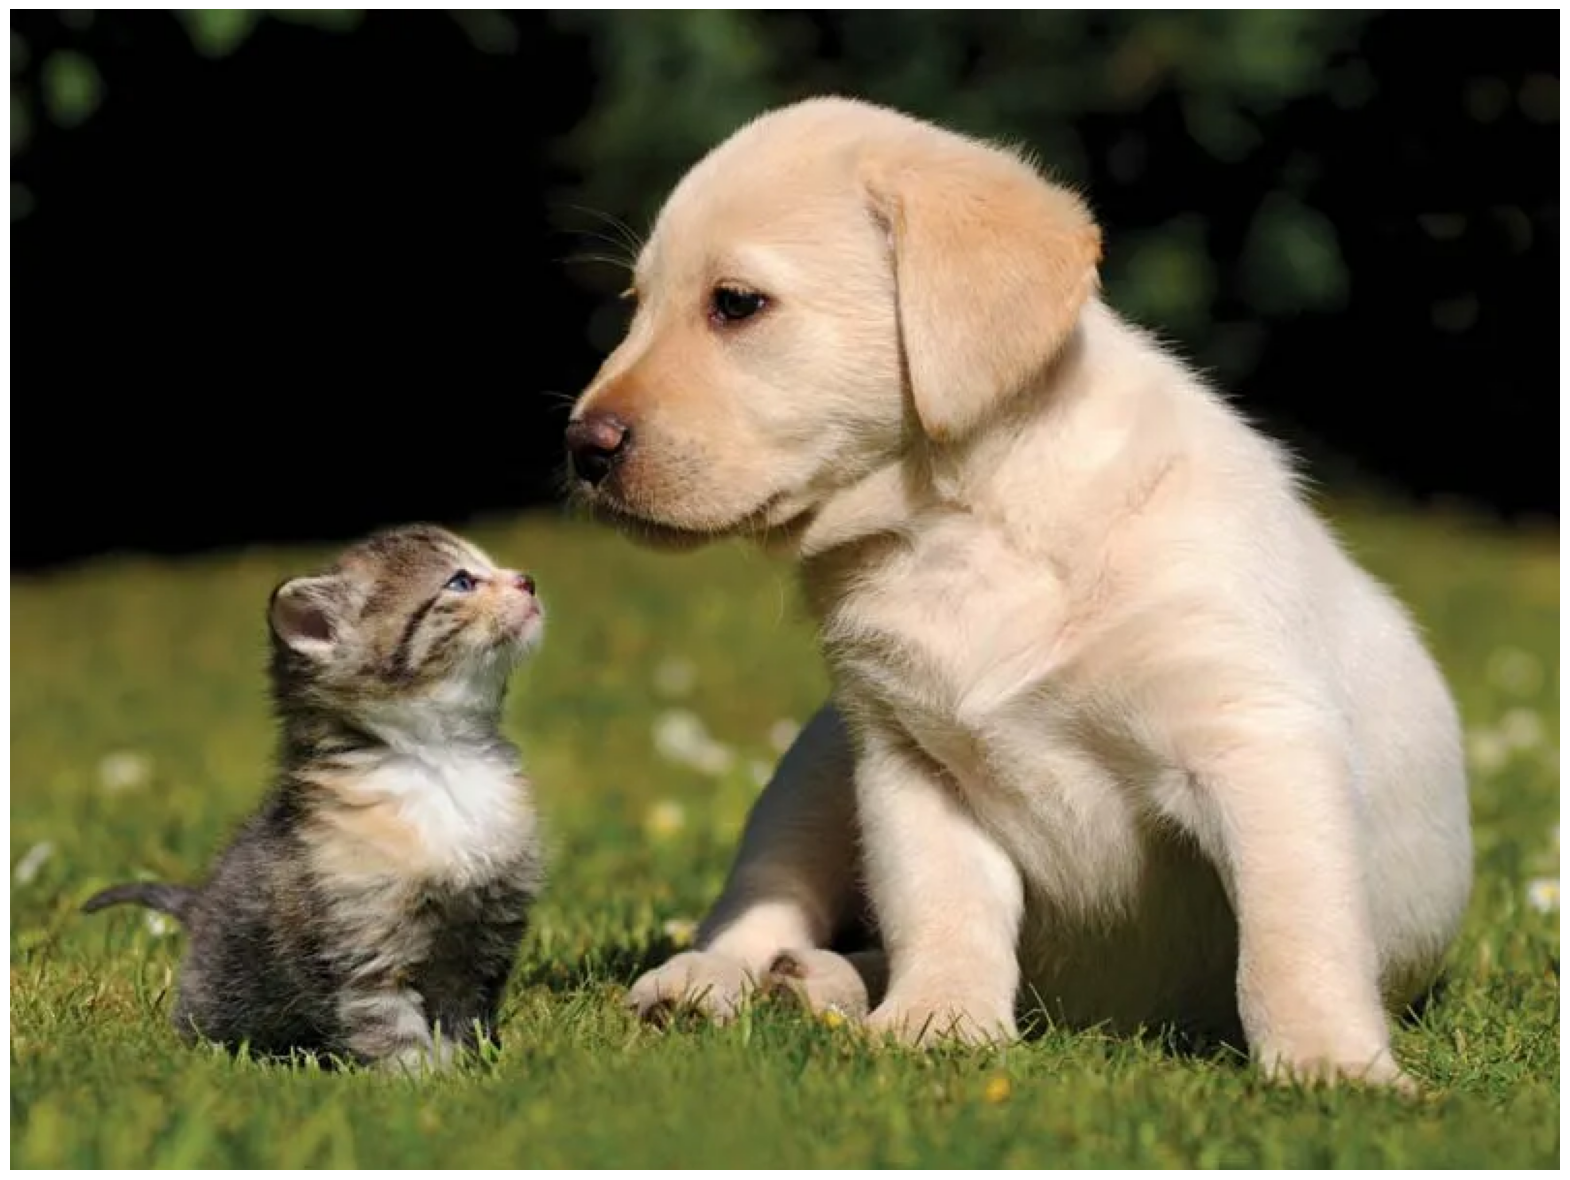

In [28]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [29]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/mnt/b432dc15-0b9a-4f76-9076-5bf99fe91d74/Hongbo/LIPEx/segment-anything/checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU:',torch.cuda.get_device_name(device=device))

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)


GPU: NVIDIA GeForce RTX 3090


To generate masks, just run `generate` on an image.

In [30]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [31]:
print('number of masks:',len(masks))
print('masks[0].keys():',masks[0].keys())
print('image.shape:',image.shape)

print(masks[0],'\n',type(masks[0]))

number of masks: 58
masks[0].keys(): dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
image.shape: (599, 800, 3)
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 137464, 'bbox': [289, 46, 464, 507], 'predicted_iou': 1.0235563516616821, 'point_coords': [[437.5, 65.515625]], 'stability_score': 0.9847244620323181, 'crop_box': [0, 0, 800, 599]} 
 <class 'dict'>


In [32]:
for i in range(len(masks)):
    print(masks[i]['area'])

137464
152461
38486
124258
147111
70668
494
2791
609
1015
38653
780
78218
481
419
294
990
465
613
1263
970
557
10922
13010
269
237
38482
504
979
193
858
820
13188
2704
229
152
324
358
851
703
382
404
421
450
493
8160
210
636
1304
3765
134
518
586
1036
503
90
392
7287


Show all the masks overlayed on the image.

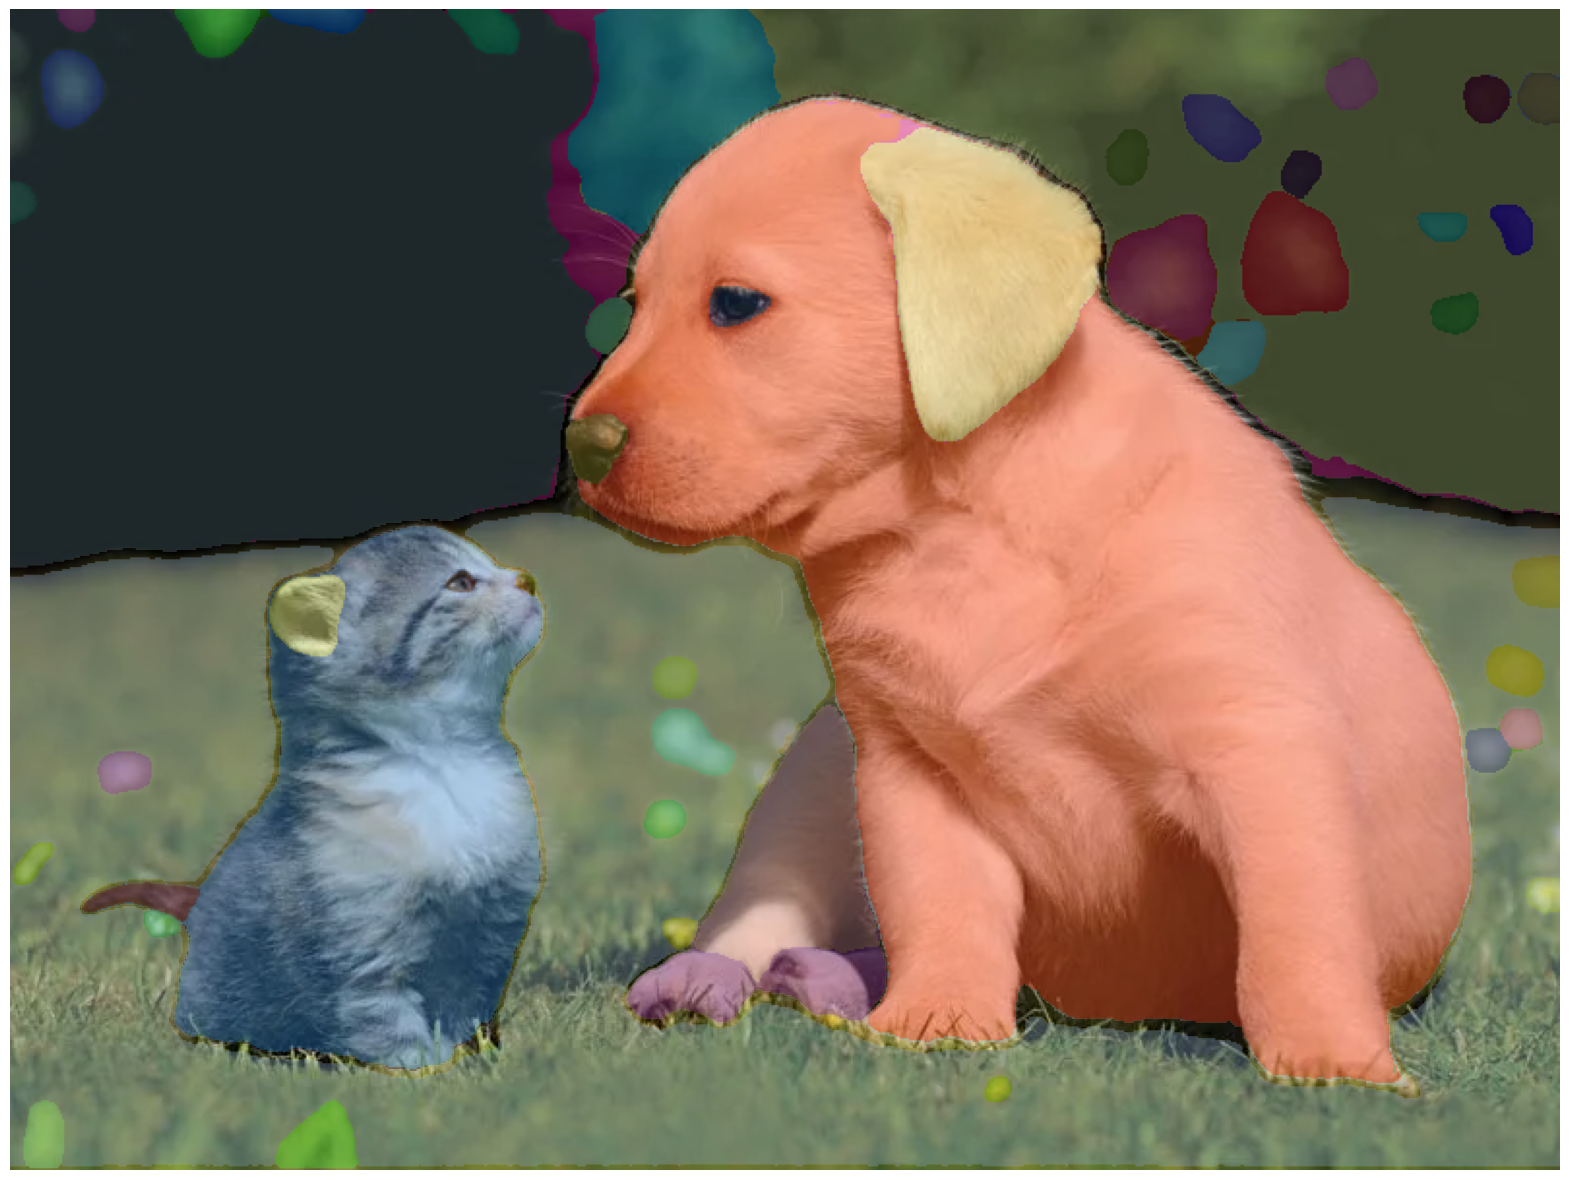

In [33]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [34]:
# For LIPEx, we need to convert the masks to a single channel image
masks = sorted(masks, key=(lambda x: x['area']))
LIPEx_segments = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
for idx in range(len(masks))[::-1]:
    cur_mask = masks[idx]['segmentation']
    LIPEx_segments[cur_mask] = idx
print(LIPEx_segments)

[[53 53 53 ... 52 52 52]
 [53 53 53 ... 52 52 52]
 [53 53 53 ... 52 52 52]
 ...
 [54 54 54 ... 54 54 54]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [35]:
print(np.unique(LIPEx_segments))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [36]:
# mask_generator_2 = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=32,
#     pred_iou_thresh=0.86,
#     stability_score_thresh=0.92,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )

In [37]:
# image_2 = cv2.imread('images/groceries.jpg')
# image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
# print("Image shape:", image_2.shape)

In [38]:
# masks2 = mask_generator_2.generate(image_2)

In [39]:
# len(masks2)

In [40]:
# plt.figure(figsize=(20,20))
# plt.imshow(image_2)
# show_anns(masks2)
# plt.axis('off')
# plt.show() 